In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [340]:
DATASET_ROOT = Path('D:\\dataset\\flybyml_dataset_v1')
data_root = DATASET_ROOT / "data"
image_root = DATASET_ROOT / "image"
meta_root = DATASET_ROOT / "meta"

# Integrity Check
see if all data, image and meta have corresponding session ids

In [341]:
# collect all possible session ids
session_ids = set()

for data_file in os.listdir(data_root):
    session_id = data_file.split(".")[0]
    session_ids.add(session_id)

for session_id in os.listdir(image_root):
    session_ids.add(session_id)

for meta_file in os.listdir(meta_root):
    session_id = meta_file.split(".")[0]
    session_ids.add(session_id)

In [342]:
# collect all orphan paths
orphan_paths = []

for session_id in session_ids:
    data_path = data_root / f"{session_id}.json"
    image_path = image_root / session_id
    meta_path = meta_root / f"{session_id}.json"

    temp = []
    if os.path.exists(data_path):
        temp.append(data_path)

    if os.path.exists(image_path):
        temp.append(image_path)

    if os.path.exists(meta_path):
        temp.append(meta_path)
    
    if len(temp) < 3:
        for path in temp:
            orphan_paths.append(path)
orphan_paths

[]

In [343]:
len(session_ids)

43

# Data Inspection

In [344]:
session_ids = list(session_ids)
def load_data(session_id):
    with open(data_root / f"{session_id}.json", "r") as f:
        return json.load(f)

752dd87c-ad8f-4a79-b000-cb673c03ecb9


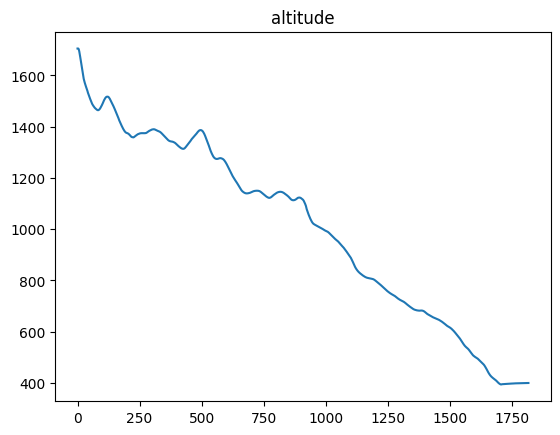

In [381]:
data_idx = 42

data = load_data(session_ids[data_idx])
print(session_ids[data_idx])

alt = []
for datum in data:
    alt.append(datum['state']['position'][2])

t = np.arange(0, len(alt), 1)
plt.title('altitude')
plt.plot(t, alt)
plt.show()

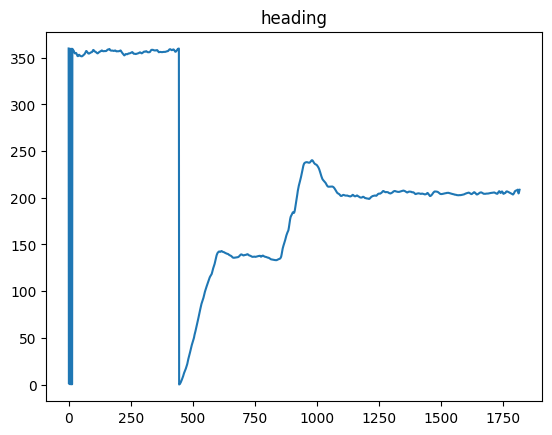

In [374]:
heading = []
for datum in data:
    heading.append(datum['state']['attitude'][2])
plt.title('heading')
plt.plot(t, heading)
plt.show()

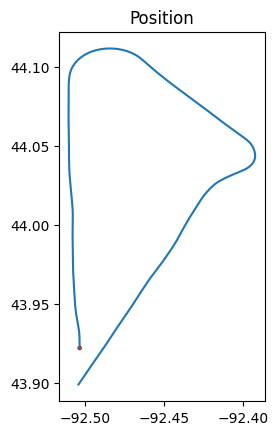

In [375]:
lat = []
lon = []
for datum in data:
    lat.append(datum['state']['position'][0])
    lon.append(datum['state']['position'][1])

fig, ax = plt.subplots()
plt.title('Position')

# starting point
circle = plt.Circle((lon[0], lat[0]), 0.001, color='r', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal', adjustable='box')

plt.plot(lon, lat)
plt.show()

## Filter Bad Training Data

In [376]:
def calc_landing_step(session_id):
    data = load_data(session_id)

    sum_alt = 0
    for step, datum in enumerate(reversed(data)):
        alt = datum['state']['position'][2]
        sum_alt += alt
        avg_alt = sum_alt / (step+1)
        alt_diff = alt - avg_alt
        if alt_diff > 1:
            return len(data) - step - 1


step = calc_landing_step(session_ids[data_idx])
step

1696

In [377]:
def calc_var_after_landing(session_id, landing_step):
    data = load_data(session_id)
    heading = []
    for datum in data[landing_step:]:
        heading.append(datum['state']['attitude'][2])
    heading = np.array(heading)
    return heading.var()

heading_variance = calc_var_after_landing(session_ids[data_idx], step)
heading_variance

1.284710235014819

In [378]:
def infer_rwy_info(session_id):
    data = load_data(session_id)
    
    step = calc_landing_step(session_id)
    datum = data[step]

    lat, lon, alt = tuple(datum['state']['position'])
    avg_bearing = 0
    for datum in data[step:]:
        avg_bearing += datum['state']['attitude'][2]
    avg_bearing /= (len(data) - step)
    return {
        'apt_id': '',
        'rwy_id': '',
        'position': [lat, lon, alt],
        'attitude': [0, 0, avg_bearing],
        'width': 0,
        'length': 0
    }

info = infer_rwy_info(session_ids[data_idx])

In [382]:
"""
with open(meta_root / f"{session_ids[data_idx]}.json", "r") as f:
    meta = json.load(f)
meta['target_rwy'] = info
with open(meta_root / f"{session_ids[data_idx]}.json", "w") as f:
    json.dump(meta, f)
meta
"""

'\nwith open(meta_root / f"{session_ids[data_idx]}.json", "r") as f:\n    meta = json.load(f)\nmeta[\'target_rwy\'] = info\nwith open(meta_root / f"{session_ids[data_idx]}.json", "w") as f:\n    json.dump(meta, f)\nmeta\n'